# Telco Customer Churn

Churn prediction refers to the analytical process of identifying customers who are more likely to discontinue using a service or terminate their subscription. Anticipating customer churn is crucial as acquiring new customers entails higher costs than retaining existing ones. Upon identifying the customers with the highest propensity to churn, we can devise targeted marketing strategies aimed at increasing the likelihood of customer retention.

In this notebook, we endeavor to forecast customer churn and examine the underlying factors that contribute to churn within the company. Our approach will involve applying different classification modeling techniques, such as logistic regression, random forest, and XGBoost, to achieve this goal

## Import Libraries

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn import over_sampling

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [27]:
dark_blue = '#1b588a'
medium_blue = '#5799c4'
light_blue = '#aedff3'

## Import Data

In [14]:
df = pd.read_csv('Telco-Customer-Churn.csv')

## Data Understanding

In [15]:
df.shape

(7043, 21)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [17]:
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


The raw data contains 7043 rows (customers) and 21 columns (features). They include:
1. customerID: An identification number assigned to each customer.
2. gender: Indicates the gender of the customer.
3. SeniorCitizen: Identifies if the customer is a senior citizen or not (1, 0).
4. Partner: Indicates if the customer has a partner or not (Yes, No).
5. Dependents: Indicates if the customer has dependents or not (Yes, No).
6. tenure: The duration, in months, for which the customer has been a client of the company.
7. PhoneService: Indicates if the customer has availed phone service or not (Yes, No).
8. MultipleLines: Indicates if the customer has multiple lines or not (Yes, No, No phone service).
9. InternetService: Indicates the type of internet service the customer is availing (DSL, Fiber optic, No).
10. OnlineSecurity: Indicates if the customer has online security or not (Yes, No, No internet service).
11. OnlineBackup: Indicates if the customer has online backup or not (Yes, No, No internet service).
12. DeviceProtection: Indicates if the customer has device protection or not (Yes, No, No internet service).
13. TechSupport: Indicates if the customer has tech support or not (Yes, No, No internet service).
14. StreamingTV: Indicates if the customer has streaming TV service or not (Yes, No, No internet service).
15. StreamingMovies: Indicates if the customer has streaming movies service or not (Yes, No, No internet service).
16. Contract: Indicates the type of contract the customer has (Month-to-month, One year, Two year).
17. PaperlessBilling: Indicates if the customer uses paperless billing or not (Yes, No).
18. PaymentMethod: Indicates the type of payment method the customer uses (Electronic check, Mailed check, Bank transfer (automatic), and Credit card (automatic)).
19. MonthlyCharges: Indicates the monthly charges paid by the customer.
20. TotalCharges: Indicates the total charges paid by the customer.
21. Churn: Our target feature that indicates if the customer has churned or not (Yes, No).

Upon examining the data type of our column, it is apparent that `TotalCharges` should be represented by numerical values. Currently, it is being represented as an object and therefore requires modification. Additionally, it has come to our attention that the `customerID` field is in fact unique, thus we can proceed to remove it from consideration

In [18]:
#change TotalCharges to float
df = df.loc[~df['TotalCharges'].str.contains(' ')]
df['TotalCharges'] = df['TotalCharges'].astype(float)

#drop customerID
df = df.drop(['customerID'], axis = 1)

## Statistical summary

In [19]:
categoricals = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 
                'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                'PaperlessBilling', 'PaymentMethod', 'Churn']
numericals = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

In [20]:
df[numericals].describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


Observations:
- In general, the minimum and maximum values for each column appear reasonable.
- `SeniorCitizen` column can be categorized as a boolean column as it only consists of values 0 or 1. Therefore, it is unnecessary to assess its symmetry.
- The `tenure` and `MonthlyCharge`s columns exhibit significant skewness, as evidenced by the notable disparity between their means and medians. Additionally, the `TotalCharges` column appears to have an asymmetrical distribution, with a skewed distribution.

In [21]:
df[categoricals].describe().T

,count,unique,top,freq
gender,7032,2,Male,3549
Partner,7032,2,No,3639
Dependents,7032,2,No,4933
PhoneService,7032,2,Yes,6352
MultipleLines,7032,3,No,3385
InternetService,7032,3,Fiber optic,3096
OnlineSecurity,7032,3,No,3497
OnlineBackup,7032,3,No,3087
DeviceProtection,7032,3,No,3094
TechSupport,7032,3,No,3472


Upon analysis, several observations have been made regarding the dataset.
- The `customerID` column contains distinct values and can be disregarded for further analysis. 
- The gender column exhibits two unique values, namely 'Male' and 'Female', with a relatively balanced distribution.
- Columns such as `Partner`, `Dependents`, `PhoneService`, `PaperlessBilling`, and `Churn` exhibit two unique values, 'yes' and 'no'. Additionally, the majority of customers do not have partners or dependents, and while most customers use phone service, few opt for multiple lines. 
- The majority of customers use internet service, with the majority opting for fiber optic while others choose DSL. However, a small proportion of customers (1526 rows) do not use internet service at all.

- Furthermore, among the customers who use internet service, **the majority do not avail themselves of additional services** such as Online Security, Online Backup, Device Protection, Tech Support, Streaming TV, and Streaming Movies as the majority value in these columns is 'No'. 
- The data also indicates that there are three types of contracts accepted by Telco, namely Month-to-month, Two-year, and One-year contracts, with the majority opting for Month-to-month contracts. 
- Likewise, four types of payment methods are used by the customers, including Electronic check, Mailed check, Bank transfer (automatic), and Credit card (automatic), with electronic check being the most popular method.

It is noteworthy that most customers have opted for paperless billing. Finally, the data indicates that out of the total number of customers, 26% have churned, with 5174 customers retaining the service while 1869 have discontinued it.

## Univariate Analysis

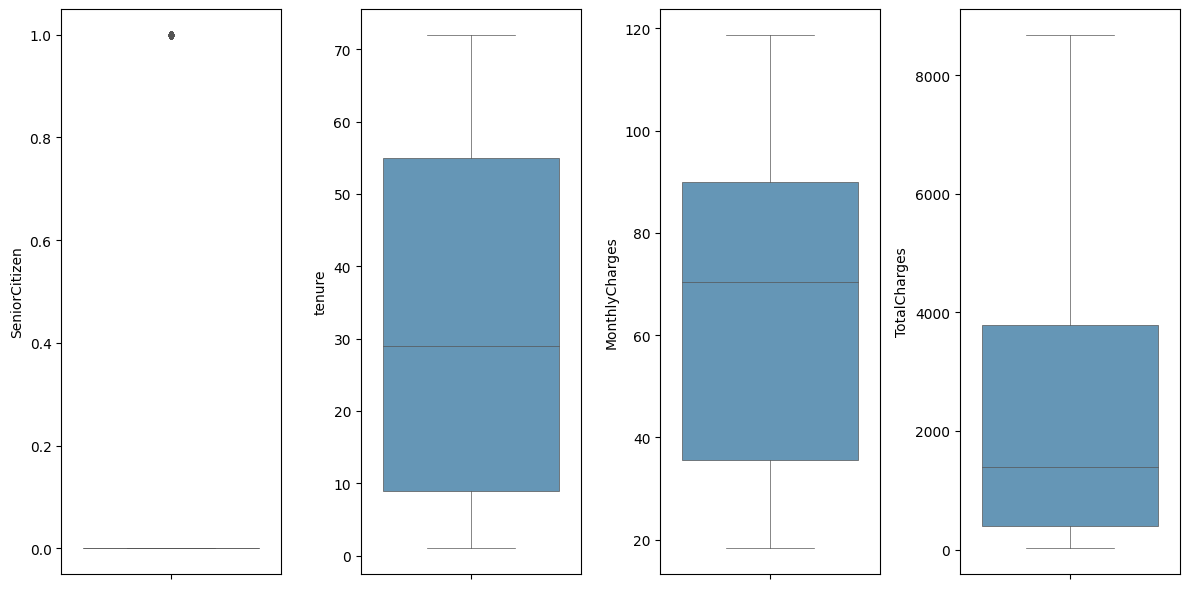

In [23]:
plt.figure(figsize=(12,6))
features = numericals
for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(y=df[features[i]], color=medium_blue, fliersize=4, linewidth=0.5)
    plt.tight_layout()

Observation:
It can be asserted that the `SeniorCitizen` column is of boolean type, as its values are restricted to either 0 or 1.

Moreover, the boxplot analysis reveals that `tenure` and `TotalCharges` exhibit positive skewness, while `MonthlyCharges` display negative skewness.

Additionally, we did not detect any outliers in any of the numerical columns.

### KDE plot for knowing the distribution form

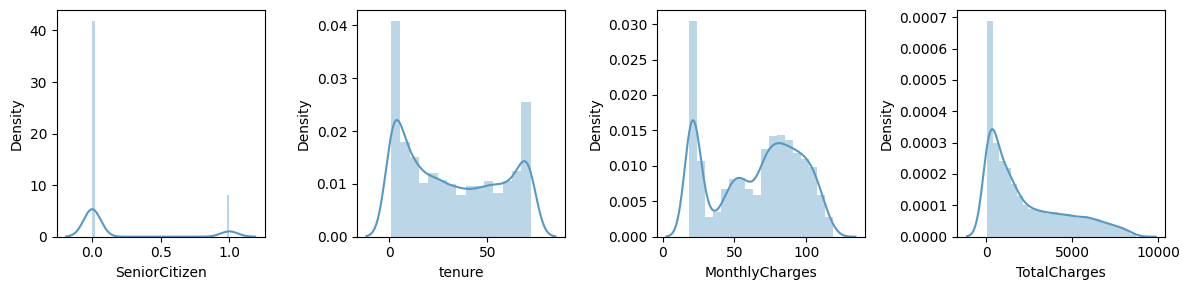

In [28]:
# adjust the figure size for better readability
plt.figure(figsize=(12,3))

features = numericals
for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.distplot(x=df[features[i]], color=medium_blue)
    plt.xlabel(features[i])
    plt.tight_layout()

Observation:
- Due to the limited discrete values, it is justifiable to disregard the interpretation of the symmetry of the `SeniorCitizen` column. Nonetheless, the visualization indicates that a significant portion of the clientele is not classified as Senior Citizens. **There exists an imbalance between the Senior Citizen and non-Senior Citizen groups.**
- The genuine continuous numerical features, namely `tenure`,` MonthlyCharges`, and `TotalCharges`, exhibit a lack of symmetry. Consequently, it is necessary to apply a transformation to approximate a normal distribution.
- The data suggests that the majority of the customers have remained with the company for only one month, while the second-largest group of customers have stayed for 72 months.
- The majority of customers appear to have monthly charges of 18.25. Since most customers stayed for only one month, the average value of total charges is approximately 18.8, which is not substantially different from their monthly charges.

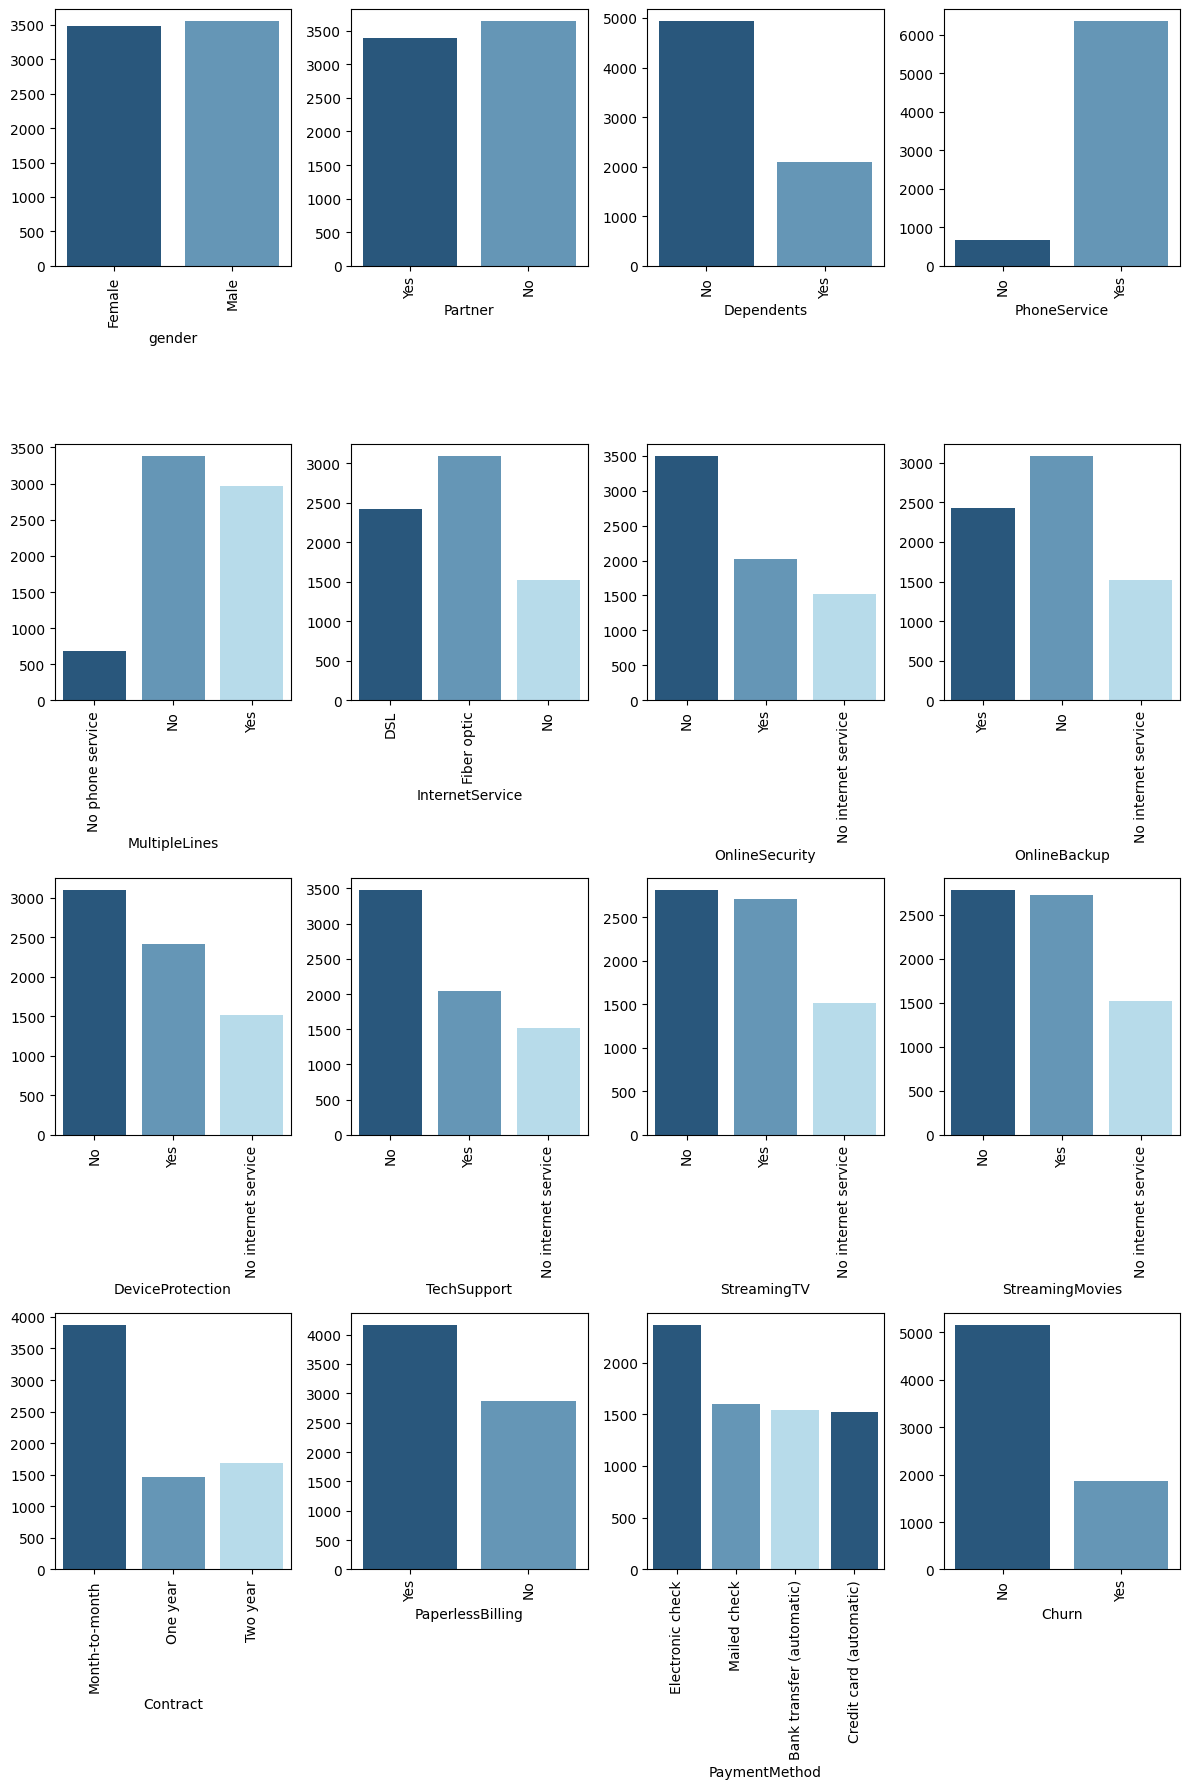

In [30]:
plt.figure(figsize=(12, 18))
features = categoricals
for i in range(0, len(features)):
    plt.subplot(4, 4, i+1)
    sns.countplot(data=df, x=features[i], palette=[dark_blue, medium_blue, light_blue])
    plt.xlabel(features[i])
    plt.ylabel('')
    plt.xticks(rotation=90)
    plt.tight_layout()

Observations:
- The `gender` and `Partner` columns exhibit good balance.
- A larger number of customers do not have dependents.
- While a majority of customers use phone service, relatively fewer opt for multiple lines.
- Most customers avail internet service, with the majority preferring Fiber optic while the rest go for DSL.
- Customers who used internet service mostly did not opt for additional services such as Online Security, Online Backup, Device Protection, Tech Support, Streaming TV and Streaming Movies, as reflected by the prevalence of the 'No' option in those columns.
- A large proportion of customers prefer Month-to-month contracts and electronic payment methods.
- Majority of customers opt for paperless billing.
- The number of customers who did not churn is significantly higher than those who did churn.

## Bivariate Analysis

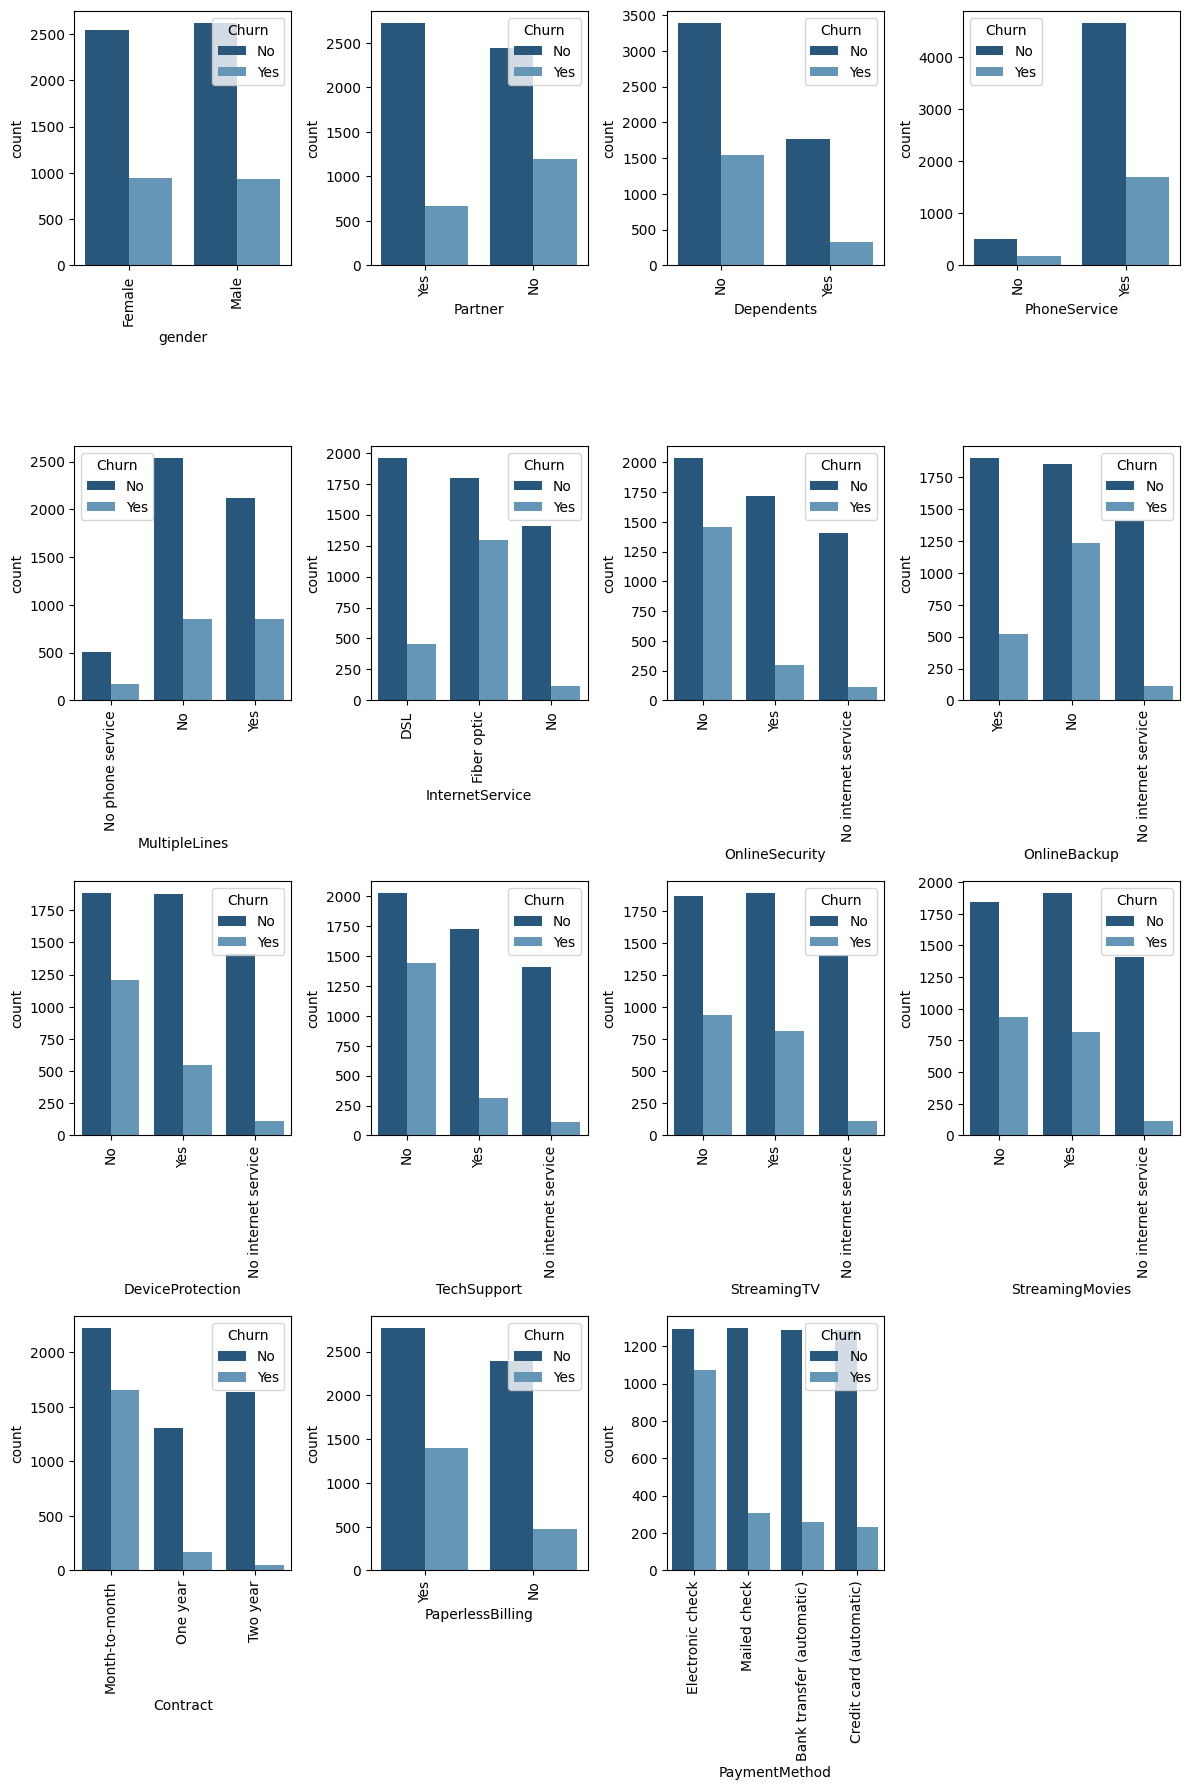

In [31]:
plt.figure(figsize=(12, 18))
features = categoricals
for i in range(0, len(features)-1):
    plt.subplot(4, 4, i+1)
    sns.countplot(data=df, hue='Churn', x=features[i], palette=[dark_blue, medium_blue, light_blue])
    plt.xlabel(features[i])
    plt.xticks(rotation=90)
    plt.tight_layout()

Based on the observations, it can be concluded that **gender does not appear to be a significant factor affecting customer churn**. 

However, certain characteristics seem to indicate a higher likelihood of churn. These include not having a partner or dependants, using phone service, using fiber optic internet service, not subscribing to additional services such as online backup or security, having a month-to-month contract, choosing paperless billing, and using electronic check payments.

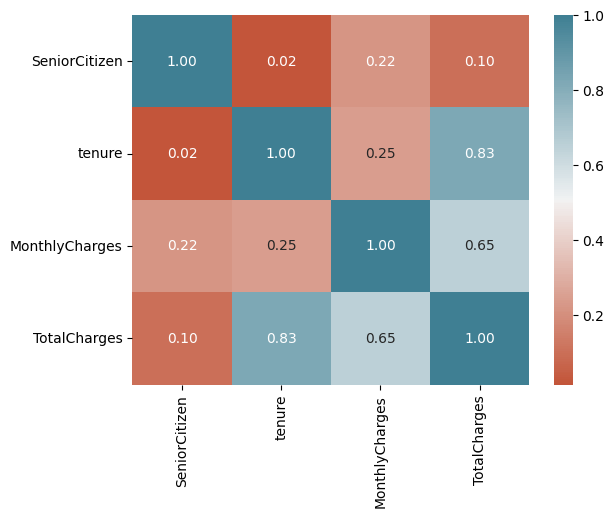

In [34]:
correlation = df.corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap=sns.diverging_palette(20, 220, n=200))
plt.show()

The data indicates a significant correlation between the variable `tenure` and `TotalCharges`, while no such correlation was found between `tenure` and `MonthlyCharges`. Additionally, a moderate correlation was observed between `MonthlyCharges` and `TotalCharges`, although the correlation coefficient was lower than 0.8.

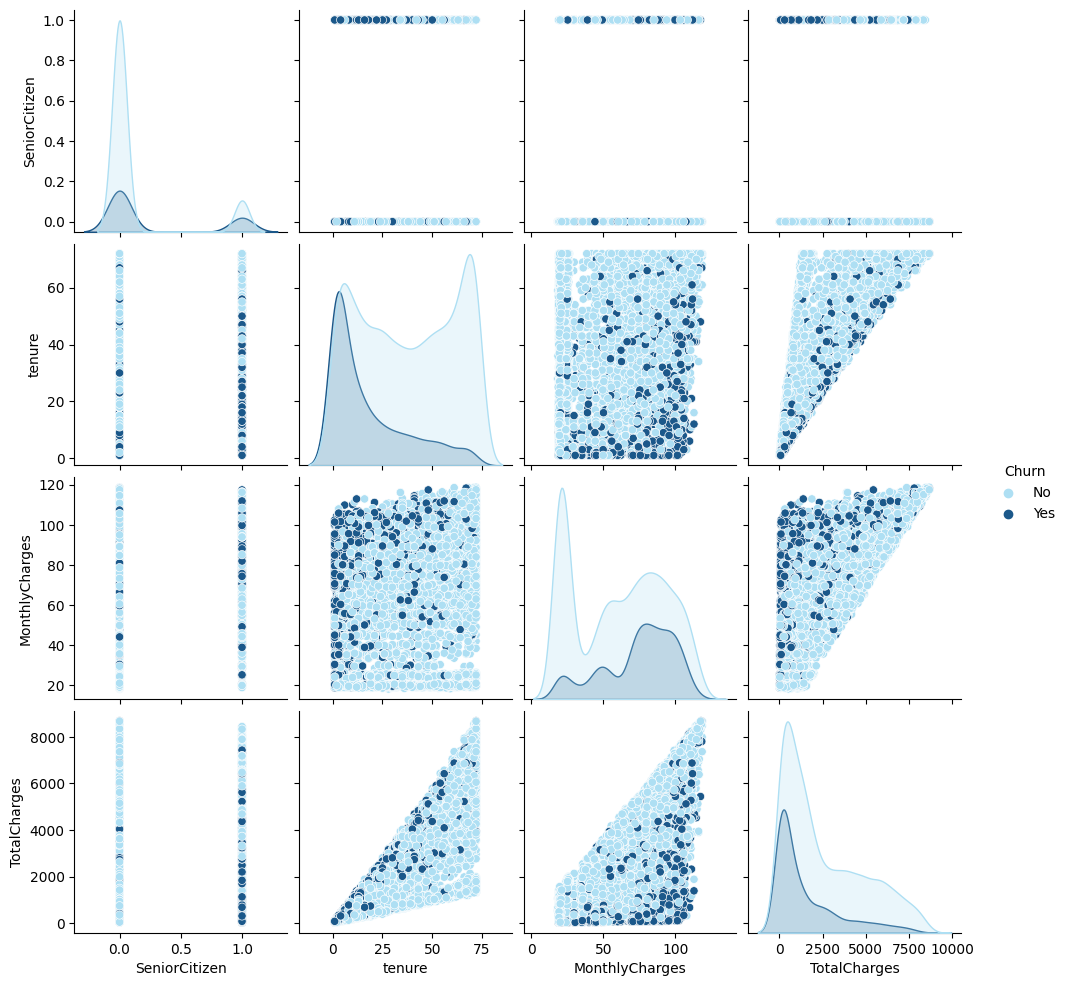

In [35]:
# pairplot of the data
sns.pairplot(df, hue='Churn', palette=[light_blue, dark_blue])
plt.show()

- Based on the data, it appears that individuals who do not qualify as senior citizens are more inclined to terminate their subscription.
- The analysis reveals that customers with shorter subscription durations are more likely to exhibit churn behavior.
- It is notable that clients with lower monthly fees are more prone to retaining their subscription, while those with higher monthly fees are more prone to terminating it.
- Of particular interest is the finding that customers with lower total charges are more likely to demonstrate churn behavior.

## The conclusion of the exploratory data analysis (EDA) is as follows:

1. The data appears to be relatively clean, with no major issues such as null values or duplicated rows.
2. The minimum and maximum values for each column seem reasonable overall.
3. Most columns with continuous numerical values display asymmetry.
4. No numerical columns contain outliers based on the boxplot analysis.
5. There is an imbalance in the distribution of the target variable, with "churn = No" being more frequent in the dataset.
6. Most customers use phone and internet services, but only a small percentage subscribe to additional services. 7. Online Security and Online Backup have a good number of subscribers.
8. Based on the bar charts, `gender` does not appear to be a significant factor in churn rate. However, several customer tendencies are associated with a higher likelihood of churn, including: no partner or dependents, using fiber optic internet and phone service, not subscribing to additional services, having a month-to-month contract, choosing paperless billing, and using electronic checks.
9. The correlation heatmap indicates that `tenure` is highly correlated with `TotalCharges`, while `MonthlyCharges` and "`TotalCharges` appear somewhat correlated with each other, but with a correlation coefficient less than 0.8.
10. Based on the pair plot, non-senior citizens are more likely to churn. Customers with shorter tenure are also more likely to churn. Customers with lower `MonthlyCharges` are more likely to stay, while those with higher `MonthlyCharges` are more likely to churn. Finally, customers with lower `TotalCharges` are more likely to churn.

## Deep-dive Exploration 

After analyzing the statistical synopsis of the data, it would be worthwhile to investigate more detailed inquiries

1. How is the the distribution of monthly charges compared to the gender and seniority?
2. How is the distribution of service that used by the customers? Is there any service that popular than others?
3. How does the distribution of charges vary depending on the services used by customers?
4. Concerning customers who use internet services, which additional services have the highest sales figures?
5. What is the most commonly selected Payment Bill option based on the type of contract?

#### 1. Distribution of Charges in respect to gender and seniority

In [16]:
charges = df.groupby(['gender', 'SeniorCitizen']).agg(
    monthly_charges = ('MonthlyCharges', 'median'),
    total_charges = ('TotalCharges', 'median')).reset_index()
charges

,gender,SeniorCitizen,monthly_charges,total_charges
0,Female,0,66.250,1270.20
1,Female,1,85.225,2263.75
2,Male,0,65.600,1309.15
3,Male,1,84.250,2251.45


The elderly population is prone to incurring greater monthly and overall expenses, indicating a higher expenditure on the service in question. This assertion is supported by the boxplot presented below.

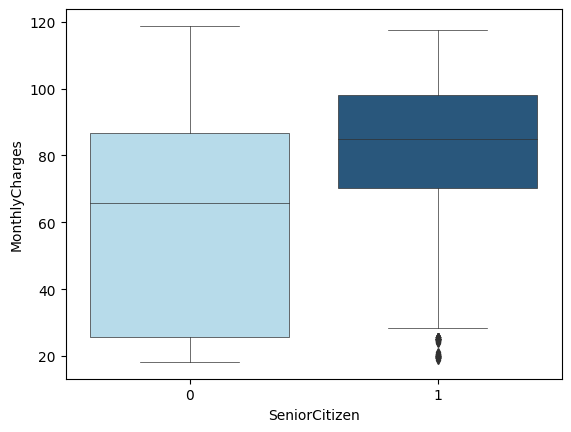

In [37]:
sns.boxplot(data=df,
            x='SeniorCitizen',
            y='MonthlyCharges',
           palette = [light_blue, dark_blue], fliersize=4, linewidth=0.5)
plt.show()

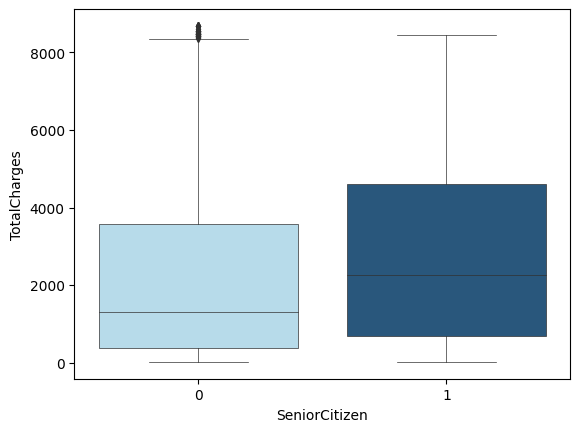

In [38]:
sns.boxplot(data=df,
            x='SeniorCitizen',
            y='TotalCharges',
           palette = [light_blue, dark_blue], fliersize=4, linewidth=0.5)
plt.show()

#### 2. Popular service

In [40]:
top_service = (df.groupby(['PhoneService','InternetService'])
            .agg(num_user=('InternetService','count'))
            .sort_values('num_user',ascending=False).reset_index())
top_service

,PhoneService,InternetService,num_user
0,Yes,Fiber optic,3096
1,Yes,DSL,1736
2,Yes,No,1520
3,No,DSL,680


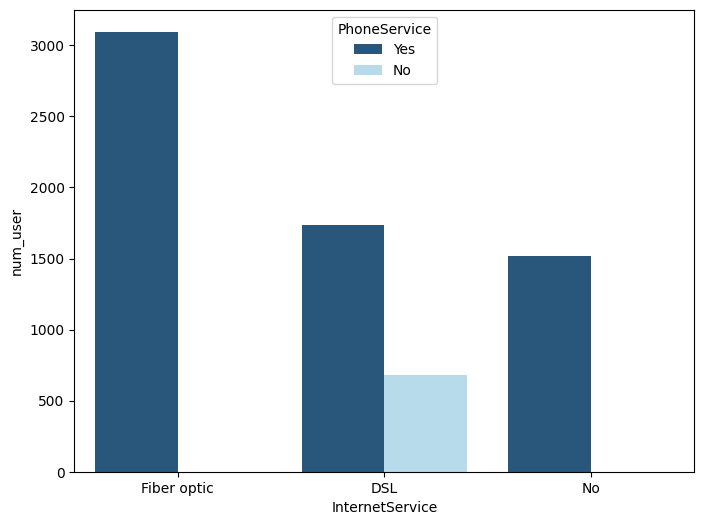

In [41]:
plt.figure(figsize=(8,6))
sns.barplot(data=top_service, x='InternetService', y='num_user', hue='PhoneService', palette=[dark_blue, light_blue])
plt.show()

**The majority of individuals employ both phone service and fiber optic** technology as their means of internet connectivity. Nevertheless, those who do not utilize phone service invariably resort to DSL as their primary internet service.

#### 3. Charge distribution based on the service

In [21]:
charges = (df.groupby(['PhoneService','InternetService']).agg(
    monthly_charges = ('MonthlyCharges', 'mean')).sort_values('monthly_charges',ascending=False).reset_index())

charges

,PhoneService,InternetService,monthly_charges
0,Yes,Fiber optic,91.500129
1,Yes,DSL,64.392713
2,No,DSL,41.992500
3,Yes,No,21.076283


The higher charge is for the one who ise phone service and Fiber optic as their `internet service`.

#### 4. Extra service that sell

In [43]:
service_list = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
service_df = pd.melt(df[df["InternetService"] != "No"][service_list]).rename({'variable':'Service', 'value': 'Subscribe'}, axis=1)
service_df

,Service,Subscribe
0,OnlineSecurity,No
1,OnlineSecurity,Yes
2,OnlineSecurity,Yes
3,OnlineSecurity,Yes
4,OnlineSecurity,No
...,...,...
33067,StreamingMovies,Yes
33068,StreamingMovies,Yes
33069,StreamingMovies,No
33070,StreamingMovies,No


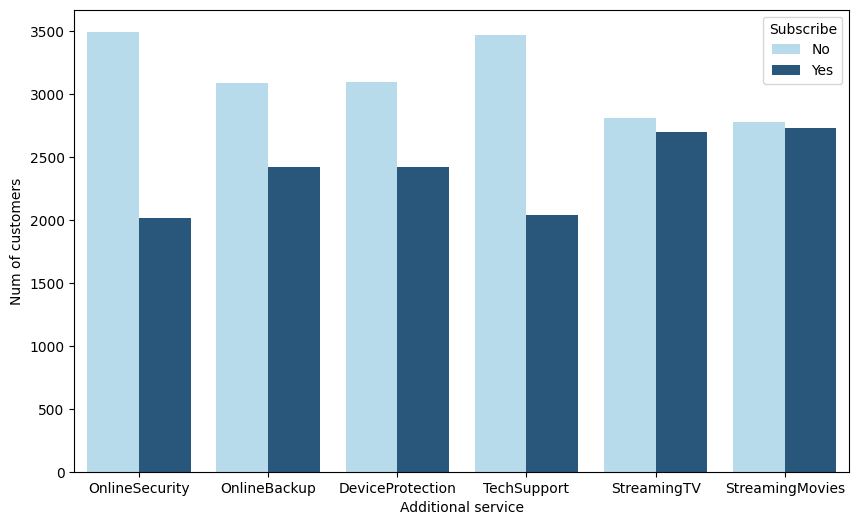

In [44]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=service_df, x='Service', hue='Subscribe', palette=[light_blue, dark_blue])
ax.set(xlabel='Additional service', ylabel='Num of customers')
plt.show()

Despite the fact that a significant portion of the customer base did not opt for supplementary amenities, it appears that **streaming movies and streaming television have emerged as the favored services** among the available options.

#### 5. Popular payment method among different contract

In [46]:
contract = df.groupby(['Contract','PaymentMethod']).agg(
    num_user =  ('PaymentMethod', 'count')).reset_index()

contract

,Contract,PaymentMethod,num_user
0,Month-to-month,Bank transfer (automatic),589
1,Month-to-month,Credit card (automatic),543
2,Month-to-month,Electronic check,1850
3,Month-to-month,Mailed check,893
4,One year,Bank transfer (automatic),391
5,One year,Credit card (automatic),398
6,One year,Electronic check,347
7,One year,Mailed check,336
8,Two year,Bank transfer (automatic),562
9,Two year,Credit card (automatic),580


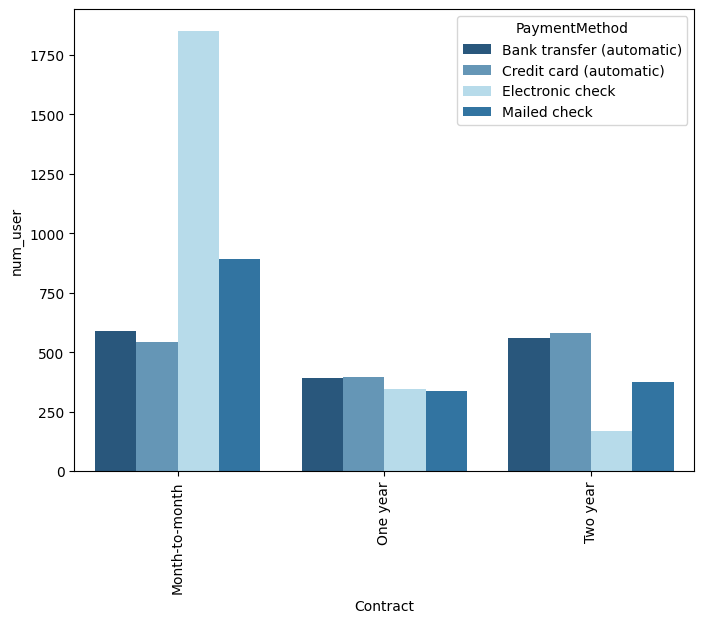

In [48]:
plt.figure(figsize=(8,6))
sns.barplot(data=contract, x='Contract', y='num_user', hue='PaymentMethod',palette=[dark_blue, medium_blue, light_blue, 'tab:blue'])
plt.xticks(rotation=90)
plt.show()

Electronic is popular among people with month-to-month contract. But for customers in Two Year contract, they prefer Automatic payment method (Bank transfer and credit card).

## Feature Encoding

**Numerical representation is often required for categorical variables by most algorithms to yield effective models**. 

Hence, variable encoding becomes necessary. Categorical variables are classified into three categories, i.e., binary, ordinal, and nominal. To determine the appropriate encoding method, we must first ascertain the category to which the variable belongs by analyzing its unique values in the column.

In [26]:
#Check number of unique value in each columns
df[categoricals].nunique()

gender              2
Partner             2
Dependents          2
PhoneService        2
MultipleLines       3
InternetService     3
OnlineSecurity      3
OnlineBackup        3
DeviceProtection    3
TechSupport         3
StreamingTV         3
StreamingMovies     3
Contract            3
PaperlessBilling    2
PaymentMethod       4
Churn               2
dtype: int64

It is evident that certain columns including `gender`, `Partner`, `Dependants`, `PaperlessBilling`, `PhoneService`, and `Churn` have two distinct values, which require encoding to binary values of 0 and 1. 

With respect to the MultipleLines column, although three values exist, we can consider 'No phone service' as equivalent to 'No' given that we already have a `PhoneService` column. We can then apply Label Encoding. In the case of the `InternetService` column, it is advisable to group Fiber Optic and DSL as Has_InternetService. Subsequently, a new column can be created indicating the specific service used, followed by the dropping of `InternetService`. Additionally, for `Contract and PaymentMethod`, we recommend using one-hot encoding.

To effectuate alterations to our data, it is advisable to replicate the original dataset and solely modify the replicated version.

In [27]:
dff = df.copy()
dff.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [28]:
# encode columns with 2 distinct value
columns_binary = ['gender',
                  'Partner',
                  'PhoneService',
                  'Dependents',
                  'PaperlessBilling',
                  'Churn']
le = preprocessing.LabelEncoder()
dff[columns_binary] = dff[columns_binary].apply(le.fit_transform)
dff.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,1,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,1,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,1,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


In [29]:
# encode MultipleLines column
dff['MultipleLines'].replace('No phone service','No', inplace=True)
le.fit(dff['MultipleLines'])
dff['MultipleLines'] = le.transform(dff['MultipleLines']) 
dff.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,1,0,0,0,34,1,0,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,1,0,0,0,2,1,0,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,1,0,0,0,45,0,0,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,0,2,1,0,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


In [30]:
# encode internet service related columns
internet_column = ['OnlineSecurity',
                   'OnlineBackup',
                   'DeviceProtection',
                   'TechSupport',
                   'StreamingTV',
                   'StreamingMovies']

for column in internet_column:
    dff[column].replace('No internet service','No', inplace=True)
    
dff[internet_column] = dff[internet_column].apply(le.fit_transform)
dff.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,1,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,1,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,1,0,0,0,45,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


In [31]:
#encode columns with more than 2 distinct values
onehot_cols = ['InternetService', 'Contract', 'PaymentMethod']
for col in onehot_cols:
    dummies = pd.get_dummies(dff[col],prefix=col)
    dff = pd.concat([dff, dummies], axis=1) 
dff.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,DSL,0,1,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,DSL,1,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,0,DSL,1,1,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,DSL,1,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,0,Fiber optic,0,0,...,0,1,0,1,0,0,0,0,1,0


In [32]:
#drop previous columns
dff = dff.drop(onehot_cols, axis = 1)
dff.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,1,0,1,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,0,1,1,0,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,1,0,1,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


Now we have our data ready for some modeling. We can first split our data, check the multicollinearity and train our data into machine learning model.

# Split the data

In the field of machine learning, data splitting is a commonly employed technique to forestall the issue of overfitting. 

Overfitting transpires when a machine learning model becomes exceedingly adept at fitting the training data, but unable to generalize and fit new data consistently. At present, we are partitioning our data into training and testing sets, with a ratio of 80:20.

Additionally, it is imperative to segregate our data into distinct entities comprising the features (X) and target variable (y).

In [33]:
X = dff.drop('Churn', axis=1)
y = dff['Churn']

X_train, X_test, y_train,y_test = train_test_split(X, y,
                                                  test_size = 0.2,
                                                  random_state = 42)

# Multicollinearity

Multicollinearity among independent variables will result in less reliable statistical inferences. Therefore, we should check them using heatmap.

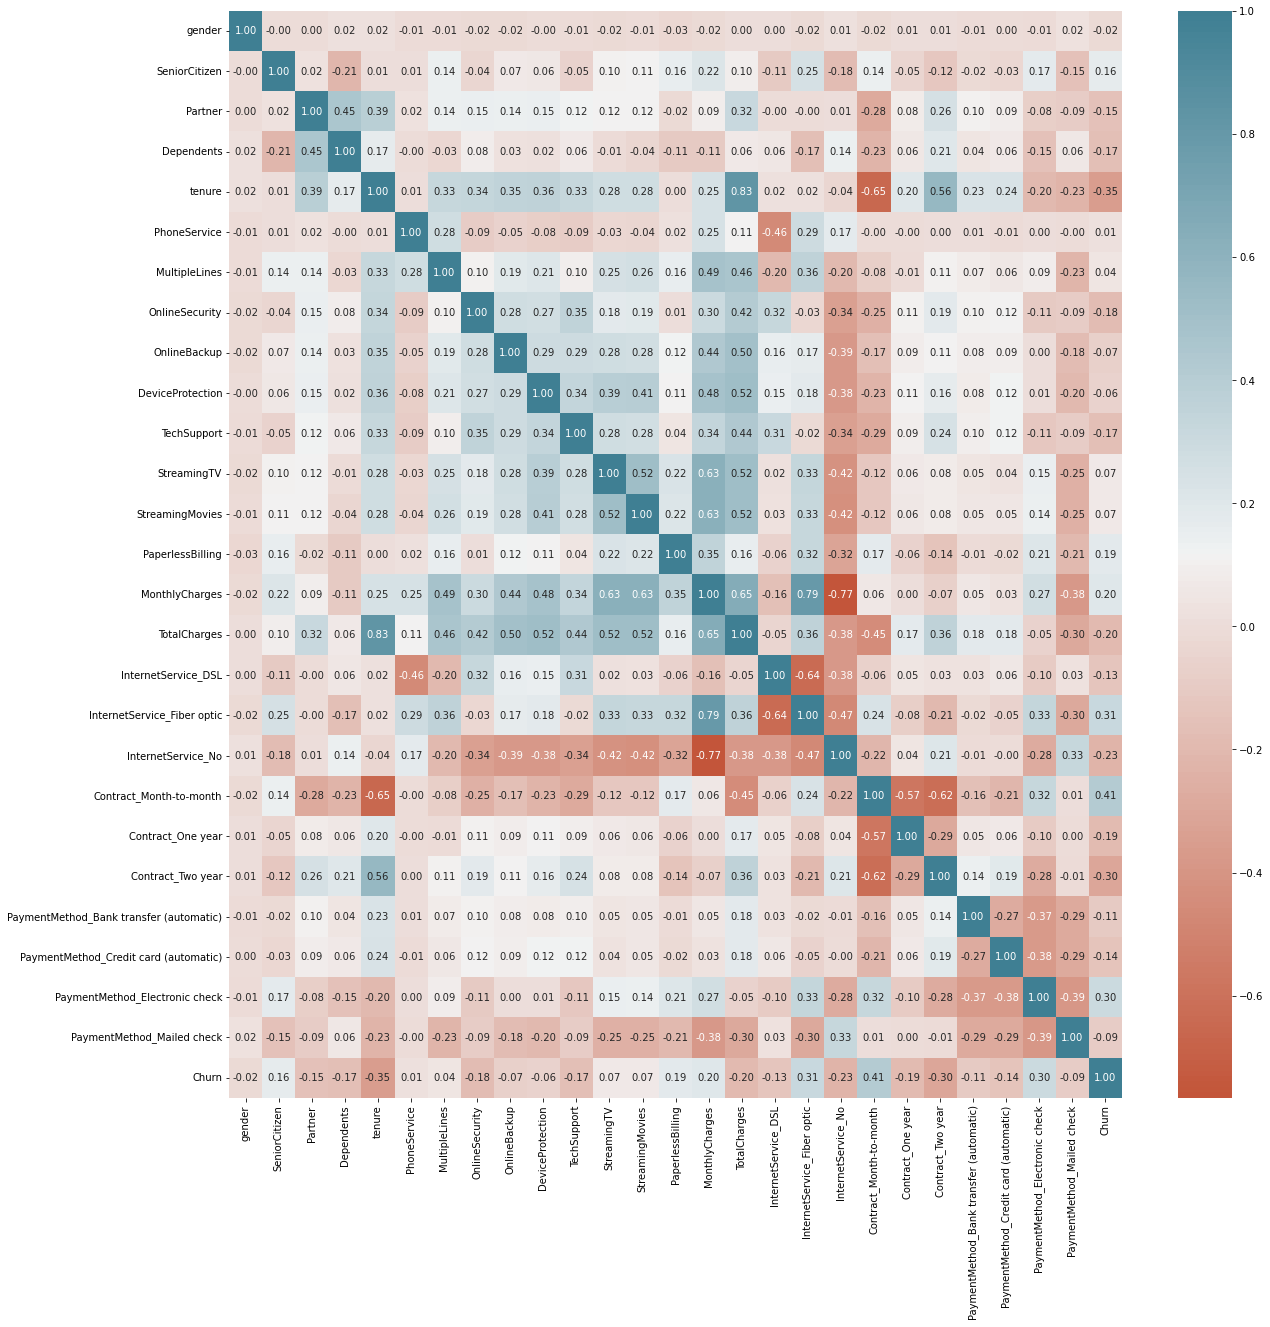

In [34]:
train = pd.concat([X_train, y_train], axis=1)
correlation = train.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation, annot=True, fmt='.2f', cmap=sns.diverging_palette(20, 220, n=200))
plt.show()

There is multicollinearity between `Tenure` and `TotalCharges`. Because `Tenure` shows higher correlation to `Churn`, we can drop `TotalCharges`.

In [35]:
#Drop redundant features in both train and test
X_train = X_train.drop('TotalCharges', axis=1)
X_test = X_test.drop('TotalCharges', axis=1)

## Choose the appropriate metric for fitting the model

In [36]:
#Check imbalance of target feature
target = y_train.value_counts().reset_index()
target.rename(columns={'index':'Churn','Churn':'freq'}, inplace=True)
target['percentage'] = round((target['freq']/target['freq'].sum())*100,2)
target

,Churn,freq,percentage
0,0,4130,73.42
1,1,1495,26.58


Owing to an uneven distribution of feature targets, accuracy is not a suitable metric for evaluation purposes. Instead, **we will rely on recall (sensitivity) to identify customers who are at the highest risk of churning**. The objective is to successfully detect a greater number of customers who are likely to churn, enabling us to implement effective business strategies to prevent customer churn.

In this context, it is preferable to predict that a customer will churn, even if they eventually do not, rather than allowing the customer to churn because we failed to detect the risk in time.

## Modeling

### Random Forest

In [37]:
#define the estimator/model
rf = RandomForestClassifier(random_state=42)

In [38]:
%%time

parameters = {
    'n_estimators': (10, 50, 100),
    'max_depth':(5, 10, 20),
}

# note: we use recall
rf_gridcv = GridSearchCV(rf, parameters, cv=5, scoring='recall')
rf_gridcv.fit(X_train, y_train)

CPU times: user 11.3 s, sys: 370 ms, total: 11.7 s
Wall time: 12.5 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': (5, 10, 20),
                         'n_estimators': (10, 50, 100)},
             scoring='recall')

#### Evaluation Metrics on Test Data

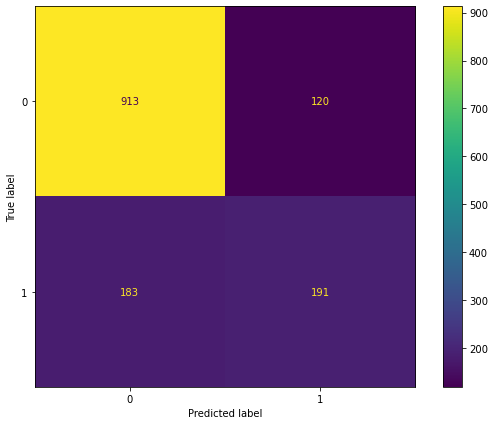

In [39]:
# the confusion matrix

fig, ax = plt.subplots(figsize=(10,7))
y_pred = rf_gridcv.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=rf_gridcv.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf_gridcv.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

According to the confusion matrix analysis, 

we have accurately predicted 913 customers who will not churn and 191 customers who will churn. 

However, the results also show that 120 customers have been incorrectly predicted to churn when in fact they will not, and 183 customers have been mistakenly predicted to not churn when they will actually churn. 

**Therefore, although we have achieved a relatively high level of success in predicting customer churn, there is still room for improvement in order to minimize the number of false positives and false negatives.**

In [40]:
y_pred = rf_gridcv.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1033
           1       0.61      0.51      0.56       374

    accuracy                           0.78      1407
   macro avg       0.72      0.70      0.71      1407
weighted avg       0.77      0.78      0.78      1407



* Based on recall metric, our model performance on the test data is 0.51, which means out of all the people who actually churn, our model has detected 51% of them.


* The precision value on the test data is 0.61, which means that from all data we predicted churn, we managed to guess 61% correctly. There are 39% of people who we think will churn when they really won't.


* I think recall value of 0.51 is not enough even it's not a life-or-death situation. So, let's try to improve our prediction by doing Random forest with oversampling (SMOTE) and try XGBoost model.

### Random Forest with SMOTE

Oversampling the minority class is one way to deal with imbalance datasets. Duplicating examples from the minority class is the simplest method, but these examples don't provide any new insight into the model. Instead, fresh examples can be created by synthesizing the old ones. Here we will use Synthetic Minority Oversampling Technique, or SMOTE as a method to oversampling for the minority class.

In [41]:
#Imbalance handling in train data

sm = over_sampling.SMOTE(random_state=42)

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print(f'''Shape of X before SMOTE: {X_train.shape}
Shape of X after SMOTE: {X_train_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_train_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (5625, 25)
Shape of X after SMOTE: (8260, 25)

Balance of positive and negative classes (%):


1    50.0
0    50.0
Name: Churn, dtype: float64

In [42]:
#define the estimator/model
rf_sm = RandomForestClassifier(random_state=42)

In [43]:
%%time

parameters = {
    'n_estimators': (10, 50, 100),
    'max_depth':(5, 10, 20)
}

# note: we use recall
rf_gridcv_sm = GridSearchCV(rf_sm, parameters, cv=5, scoring='recall')
rf_gridcv_sm.fit(X_train_sm, y_train_sm)

CPU times: user 14.3 s, sys: 384 ms, total: 14.7 s
Wall time: 14.6 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': (5, 10, 20),
                         'n_estimators': (10, 50, 100)},
             scoring='recall')

In [44]:
cv_result = pd.DataFrame(rf_gridcv_sm.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
4,"{'max_depth': 10, 'n_estimators': 50}",0.862954,1
5,"{'max_depth': 10, 'n_estimators': 100}",0.860291,2
3,"{'max_depth': 10, 'n_estimators': 10}",0.857143,3
1,"{'max_depth': 5, 'n_estimators': 50}",0.850605,4
2,"{'max_depth': 5, 'n_estimators': 100}",0.846973,5
8,"{'max_depth': 20, 'n_estimators': 100}",0.843584,6
7,"{'max_depth': 20, 'n_estimators': 50}",0.842857,7
0,"{'max_depth': 5, 'n_estimators': 10}",0.835835,8
6,"{'max_depth': 20, 'n_estimators': 10}",0.817676,9


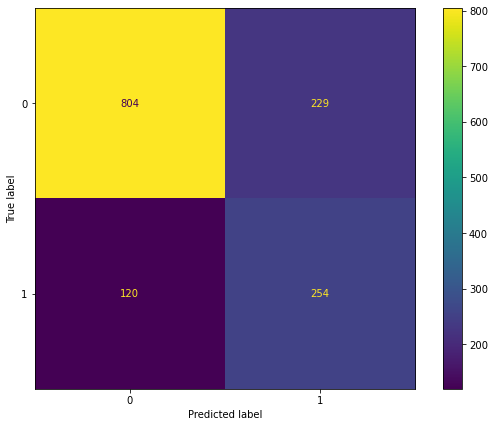

In [45]:
# the confusion matrix

fig, ax = plt.subplots(figsize=(10,7))
y_pred_sm = rf_gridcv_sm.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, y_pred_sm, labels=rf_gridcv_sm.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf_gridcv_sm.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

Based on confusion matrix:

* We successfully predicted 804 customers who don't churn and 254 who churn
* There are 229 customers who are predicted to churn when they actually won't
* There are 120 customers who are predicted to not churn when they actually churn

In [46]:
y_pred = rf_gridcv_sm.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.78      0.82      1033
           1       0.53      0.68      0.59       374

    accuracy                           0.75      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.75      0.76      1407



* Our prediction show much improvement after oversampling (SMOTE)

* Based on recall metric, our model performance on the test data is 0.68, which means out of all the people who actually churn, our model has detected 68% of them. With proper strategy, we can prevent 68% of people who churn!

* The precision value on the test data is 0.53, which means that from all data we predicted churn, we managed to guess 53% correctly. However, we don't really care about our precision metric.

### XGBoost

* For the sake of curiosity, I will try XGBoost because it is said that if we tune 'scale_post_weight' parameter, it can handle data imbalance.
* In addition I will tune 'min_child_weight' and 'max_depth' to control overfitting.

In [47]:
xgboost = xgb.XGBClassifier()

In [48]:
%%time

parameters = {
        'min_child_weight': [1, 5, 10],
        'scale_pos_weight': [1, 3, 5, 10],
        'max_depth': [3, 5, 10],
        }

# note: we use recall
xgb_gridcv = GridSearchCV(xgboost, parameters, cv=5, scoring='recall')
xgb_gridcv.fit(X_train, y_train) 

CPU times: user 6min 29s, sys: 10.8 s, total: 6min 40s
Wall time: 2min 8s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...hot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'max_depth': [3, 5, 10],
                         'min_child_weight': [1, 5, 10],
                         'scale_pos_weight': [1, 3, 5, 10]},
             scoring='recall')

In [49]:
cv_result = pd.DataFrame(xgb_gridcv.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
11,"{'max_depth': 3, 'min_child_weight': 10, 'scal...",0.909030,1
3,"{'max_depth': 3, 'min_child_weight': 1, 'scale...",0.901672,2
7,"{'max_depth': 3, 'min_child_weight': 5, 'scale...",0.901003,3
6,"{'max_depth': 3, 'min_child_weight': 5, 'scale...",0.852843,4
10,"{'max_depth': 3, 'min_child_weight': 10, 'scal...",0.850167,5
23,"{'max_depth': 5, 'min_child_weight': 10, 'scal...",0.847492,6
2,"{'max_depth': 3, 'min_child_weight': 1, 'scale...",0.842140,7
19,"{'max_depth': 5, 'min_child_weight': 5, 'scale...",0.831438,8
15,"{'max_depth': 5, 'min_child_weight': 1, 'scale...",0.803344,9
22,"{'max_depth': 5, 'min_child_weight': 10, 'scal...",0.789967,10


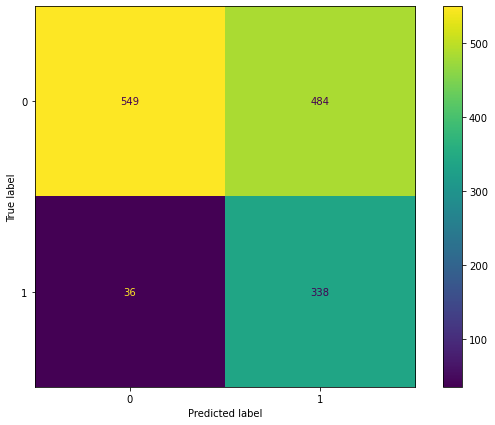

In [50]:
# the confusion matrix

fig, ax = plt.subplots(figsize=(10,7))
y_pred = xgb_gridcv.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=xgb_gridcv.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=xgb_gridcv.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

As per the confusion matrix analysis, the following results have been obtained:

- A total of 549 customers who will not churn and 338 who will churn have been accurately predicted.
- However, there are 484 instances where customers are predicted to churn, but in reality, they will not.
- Additionally, there are 36 cases where customers are predicted to stay, but they will, in fact, churn.

In [51]:
y_pred = xgb_gridcv.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.53      0.68      1033
           1       0.41      0.90      0.57       374

    accuracy                           0.63      1407
   macro avg       0.67      0.72      0.62      1407
weighted avg       0.80      0.63      0.65      1407



Our analysis indicates significant progress in our predictions.

Presently, our model has exhibited a performance of 0.90 on the test data, signifying that it has detected 93% of individuals who have churned. With effective strategies, we can prevent 90% of customer churn.

The precision value on the test data is 0.41, which indicates that we accurately predicted 41% of all churns.

We observe that a higher recall value is accompanied by lower precision. This is reasonable since recall and precision possess a trade-off relationship. Nonetheless, our priority lies in obtaining a higher recall value, and we are content with that, regardless of the precision value.

## Conclusion

Upon conducting the modeling analysis, it has become evident that **XGBoost proves to be the most suitable model for imbalanced data**. 

However, it is crucial to note that feature selection has not yet been implemented in this analysis. Feature selection is an essential process that involves the selection of relevant features that significantly impact the dataset. 

Incorporating feature selection in the analysis could potentially enhance the overall outcome.